# The HFM library - A fast marching solver with adaptive stencils

## Part : Application examples
## Chapter : Fisher-Rao distances

The application examples presented in this notebook were suggested by Stephen Taylor,
Assistant Professor of Finance at NJIT.


## The fisher-Rao metric

Consider a probability distribution, defined by a density $p(x,\theta)$ w.r.t. some base measure denoted $\mathrm{d} x$ on a probability space $X$. Our probability distribution also depends on a $\theta$ within some open domain $\Theta \subset \mathbb R^n$.
The Fisher-Rao metric, or Fisher information metric, is a Riemannian metric on the parameter space $\Theta$. It is defined as follows:
\begin{equation*}
	{\mathcal M}(\theta) 
    := E[\nabla_\theta \ln p \otimes \nabla_\theta \ln p] 
    = \int_X \nabla_\theta \ln p(x,\theta) \, \nabla_\theta \ln p(x,\theta)^T \, p(x,\theta) \mathrm{d} x.
\end{equation*}
Interestingly, thanks to an algebraic simplification, the Fisher-Rao metric is also the negative mean of a hessian.
\begin{equation*}
	-{\mathcal M}(\theta) = E[\nabla^2_\theta \ln p] = \int_X \nabla^2_\theta \ln p(x,\theta) \, p(x,\theta) \mathrm{d} x.
\end{equation*}

[**Summary**](Summary.ipynb) of volume Fast Marching Methods, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. The univariate Gaussian](#1.-The-univariate-Gaussian)



This Python&reg; notebook is intended as documentation and testing for the [HamiltonFastMarching (HFM) library](https://github.com/mirebeau/HamiltonFastMarching), which also has interfaces to the Matlab&reg; and Mathematica&reg; languages. 
More information on the HFM library in the manuscript:
* Jean-Marie Mirebeau, Jorg Portegies, "Hamiltonian Fast Marching: A numerical solver for anisotropic and non-holonomic eikonal PDEs", 2019 [(link)](https://hal.archives-ouvertes.fr/hal-01778322)

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

In [1]:
eikonal_mode = 'cpu'

## 0. Importing the required libraries.

<!---In this series of notebooks, input and output to the HamiltonFastMarching library is based on files written on the disk. This particularly simple to install, but a bit ugly and not much scalable. Alternatively direct link based on boost-python is also available, as discussed in the [summary](http://nbviewer.jupyter.org/urls/rawgithub.com/Mirebeau/HFM_Python_Notebooks/master/Summary.ipynb).--->

In [2]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('FisherRao','FMM'))

In [3]:
from agd import Eikonal
from agd import Metrics
from agd.Plotting import savefig; #savefig.dirName = 'Figures/FisherRao'

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
if eikonal_mode == 'gpu':
    import cupy
    import agd.AutomaticDifferentiation as ad
    np = ad.functional.decorate_module_functions(cupy,ad.cupy_generic.set_output_dtype32) 
    plt = ad.functional.decorate_module_functions(plt,ad.cupy_generic.cupy_get_args)
    Eikonal.dictIn.default_mode = eikonal_mode

## 1. The univariate Gaussian

Gaussian distributions on the real line are determined by two parameters: their mean $\mu$, and standard deviation $\sigma$. The parameter is thus a pair $\theta = (\mu,\sigma)$ in the half space $\mathbb R \times \mathbb R^{++}$.
\begin{equation*}
p(x, (\mu,\sigma)) := \frac 1 {\sqrt{2 \pi \sigma^2}} \exp\Big( - \frac{(x-\mu)^2}{2 \sigma^2}\Big).
\end{equation*}

In [6]:
hfmIn = Eikonal.dictIn({'model':'Riemann2'}) # Adequate model for two dimensional Riemannian metrics.

In this notebook, we compute distance maps and minimal geodesics for this metric, on the subdomain 
$[-2,2] \times [0,1]$, that we discretize on a $4n \times n$ grid.

In [7]:
# Create the parameter space
n=100
hfmIn.SetRect(sides=[[-2,2],[0,1]],dimx=4*n)
mu,sig = hfmIn.Grid()

The Fisher-Rao metric has a simple and explicit expression:
\begin{equation*}
    \mathcal M(\theta) := 
    \frac 1 {\sigma^2}
    \begin{pmatrix}
    1 & 0 \\
    0 & 2
    \end{pmatrix}.
\end{equation*}

In [9]:
hfmIn['metric'] = Metrics.Riemann.from_diagonal((1/sig**2, 2/sig**2))                       
# In view of the specific form of the metric, the simpler model Isotropic2 would also have fitted.

We next set the seed for our front propagation, and the tips from where geodesics are backtracked.

In [10]:
hfmIn['seed'] = [0,0.3] # A single seed
hfmIn.SetUniformTips((4,3))

In [11]:
hfmIn['exportValues'] = 1
hfmIn['order'] = 2

In [12]:
hfmOut = hfmIn.Run()

Setting the kernel traits.
Prepating the domain data (shape,metric,...)
Preparing the problem rhs (cost, seeds,...)
Preparing the GPU kernel
Running the eikonal GPU kernel
GPU kernel eikonal ran for 0.0424807071685791 seconds, and 43 iterations.
Post-Processing


Casting output of function linspace from float64 to float32


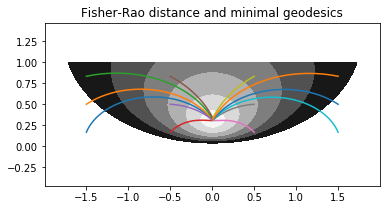

In [13]:
fig = plt.figure(figsize=[6,3]); plt.title('Fisher-Rao distance and minimal geodesics'); plt.axis('equal'); 
plt.contourf(mu,sig,hfmOut['values'],cmap='Greys',levels=np.linspace(0,3,7));  # Display the value function. 
for geo in hfmOut['geodesics']:  plt.plot(*geo) 
savefig(fig,"FisherRao_Gaussian1D.png")

Interestingly, by a suitable rescaling of the axes, the level lines of the distance function, and the geodesics, are turned into (euclidean) circles.

Casting output of function linspace from float64 to float32


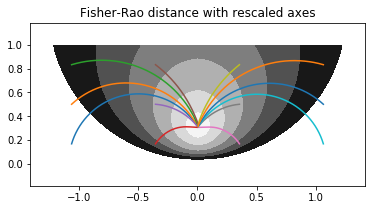

In [14]:
rho = 1./np.sqrt(2)
fig = plt.figure(figsize=[6,3]); plt.title('Fisher-Rao distance with rescaled axes'); plt.axis('equal'); 
plt.contourf(rho*mu,sig,hfmOut['values'],cmap='Greys',levels=np.linspace(0,3,7));  # Display the value function.
for geo in hfmOut['geodesics']:  plt.plot(rho*geo[0],geo[1]) 